In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris

# Plotting style

plt.style.use('science')
plt.rcParams['figure.figsize'] = (7,5)
plt.rcParams['font.size'] = 15
plt.rcParams['text.usetex'] = True

In [2]:
np.random.seed(0)

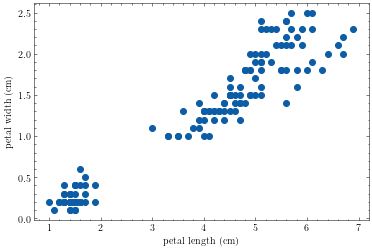

In [3]:
# Load data and plot. This time it is unsupervised

iris = load_iris()
X = iris.data[:, 2:] # Selecting the two last columns

features_names = iris.feature_names

# Plotting

plt.scatter(X[:,0], X[:,1])
plt.xlabel(features_names[2])
plt.ylabel(features_names[3])
plt.show()

In [4]:
class FrankKMeans:
    def __init__(self, k):
        self.k = k
    
    @staticmethod
    def _get_distance(Xi, Xj):
        return np.linalg.norm(Xi-Xj)
    
    def _init_centroids(self, X):
        rng = np.random.default_rng()
        self.centroids_ = rng.choice(X, size=self.k, replace=False)
    
    def _get_distance_from_centroids(self, X):
        self.distances_ = np.zeros((X.shape[0], self.k))
        
        for j in range(self.k):
            for i in range(X.shape[0]):
                self.distances_[i,j] = self._get_distance(X[i], self.centroids_[j])
    
    def _assign_clusters(self):
        self.clusters_ = np.argmin(self.distances_, axis=1)
        
    def _update_centroids(self, X):
        updated_centroids = np.zeros(self.centroids_.shape)
        for j in range(self.k):
            updated_centroids[j] = X[self.clusters_ == j].mean(axis=0)
        return updated_centroids
    
    def _get_centroids_max_change(self, new_centroid, old_centroid):
        centroid_changes = np.linalg.norm((new_centroid - old_centroid), axis=0)
        self.centroid_max_change_ = np.max(centroid_changes)
        
    def _get_inertia(self):
        self.inertia_ = np.min(self.distances_**2, axis=1).sum()
                 
    def fit(self, X, y=None, n_trials=100, tol=1e-3, n_init=3):
        
        self.params_ = []
        
        for n in range(n_init):
        
            self.X = X

            self._init_centroids(self.X)

            for i in range(n_trials):
                self._get_distance_from_centroids(self.X)
                self._assign_clusters()
                updated_centroids = self._update_centroids(self.X)
                self._get_centroids_max_change(updated_centroids, self.centroids_)
                self.centroids_ = updated_centroids.copy()

                if self.centroid_max_change_ < tol:
                    self.n_ = i+1
                    self._get_inertia()
                    self.params_.append([self.inertia_, self.centroids_, self.n_]) 
                    break
        
        self.best_n_ = np.argmin(np.array(self.params_, dtype=object)[:,0])
        self.inertia_, self.centroids_, self.n_ = self.params_[self.best_n_]
    
    def predict(self, X):
        self._get_distance_from_centroids(X)
        self._assign_clusters()
        return self.clusters_

In [5]:
# Running my implementation

frank_kmeans = FrankKMeans(k=3)
frank_kmeans.fit(X)
frank_clusters = frank_kmeans.predict(X)

In [6]:
# Sklearn implementation

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X)
sklearn_clusters = kmeans.predict(X)

In [7]:
# Build feature space for a Voronoi plot

x_space = np.linspace(0.8, 7.1, 150)
y_space = np.linspace(0.0, 2.7, 150)

xx, yy = np.meshgrid(x_space, y_space)

X_space = np.c_[xx.ravel(), yy.ravel()]

# Frank's predict
Z_frank = frank_kmeans.predict(X_space)
Z_frank = Z_frank.reshape(xx.shape)

# Sklearn's predict
Z_sklearn = kmeans.predict(X_space)
Z_sklearn = Z_sklearn.reshape(xx.shape)

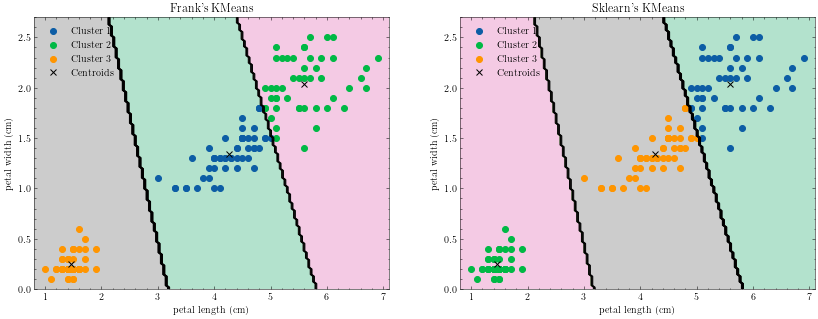

In [8]:
# Plotting

plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.contourf(xx, yy, Z_frank, extent=(0.8, 7.1, 0.0, 2.7), cmap='Pastel2')
plt.contour(xx, yy, Z_frank, extent=(0.8, 7.1, 0.0, 2.7), linewidths=1, colors='k')
plt.scatter(X[:,0][frank_clusters == 0], X[:,1][frank_clusters == 0], label='Cluster 1')
plt.scatter(X[:,0][frank_clusters == 1], X[:,1][frank_clusters == 1], label='Cluster 2')
plt.scatter(X[:,0][frank_clusters == 2], X[:,1][frank_clusters == 2], label='Cluster 3')
plt.scatter(frank_kmeans.centroids_[:, 0], frank_kmeans.centroids_[:,1], marker='x', c='k',label='Centroids')
plt.xlabel(features_names[2])
plt.ylabel(features_names[3])
plt.xlim(0.8, 7.1)
plt.ylim(0.0, 2.7)
plt.legend()
plt.title("Frank's KMeans")

plt.subplot(1,2,2)
plt.contourf(xx, yy, Z_sklearn, extent=(0.8, 7.1, 0.0, 2.7), cmap='Pastel2')
plt.contour(xx, yy, Z_sklearn, extent=(0.8, 7.1, 0.0, 2.7), linewidths=1, colors='k')
plt.scatter(X[:,0][sklearn_clusters == 0], X[:,1][sklearn_clusters == 0], label='Cluster 1')
plt.scatter(X[:,0][sklearn_clusters == 1], X[:,1][sklearn_clusters == 1], label='Cluster 2')
plt.scatter(X[:,0][sklearn_clusters == 2], X[:,1][sklearn_clusters == 2], label='Cluster 3')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:,1], marker='x', c='k',label='Centroids')
plt.xlabel(features_names[2])
plt.ylabel(features_names[3])
plt.xlim(0.8, 7.1)
plt.ylim(0.0, 2.7)
plt.legend()
plt.title("Sklearn's KMeans")

plt.show()

In [9]:
# Compare inertia obtained

print(f'Inertia (Sklearn): {kmeans.inertia_}')
print(f'Inertia (Frank): {frank_kmeans.inertia_}')

Inertia (Sklearn): 31.371358974358984
Inertia (Frank): 31.371358974358976
